# Instacart Market Basket Analysis - ML

- RFM 분석 기반 세분화 전략 및 머신러닝 기반 재구매 예측 프로젝트에 사용된 ML 코드 정리입니다.

## Libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from xgboost import XGBClassifier
from typing_extensions import dataclass_transform


In [ ]:
# 훈련 데이터와 테스트 데이터 불러오기
orders = pd.read_csv('/path/to/orders.csv')
order_products_prior = pd.read_csv('/path/to/order_products__prior.csv')
order_products_train = pd.read_csv('/path/to/order_products__train.csv')
products = pd.read_csv('/path/to/products.csv')
test = pd.read_csv('/path/to/test.csv')  # 테스트 데이터

## 1️⃣ Data Preprocessing

In [ ]:
# 결측치는 처음 구매 시점으로 0으로 Null 값 추가, 'reordered' 결측치 제거
df['days_since_prior_order'] = df['days_since_prior_order'].fillna(0).astype(int)
df.dropna(subset=['reordered'], inplace=True)

## 2️⃣ Feature Engineering
- 고객 중심으로 다양한 피처 생성 진행



- 재구매율 확인을 위한 공식 활용
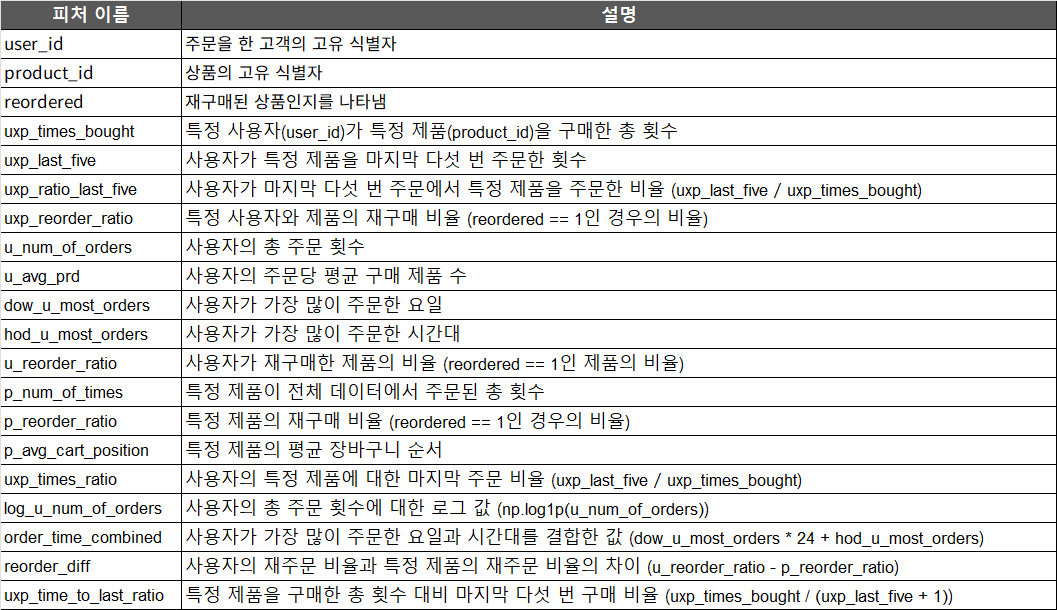

In [ ]:
# 사용자별 피처 생성
user_data = orders.groupby('user_id').agg({
    'order_id': 'nunique',  # 총 주문 횟수
    'order_dow': lambda x: x.mode()[0],  # 가장 많이 주문한 요일
    'order_hour_of_day': lambda x: x.mode()[0],  # 가장 많이 주문한 시간대
}).rename(columns={
    'order_id': 'u_num_of_orders',
    'order_dow': 'dow_u_most_orders',
    'order_hour_of_day': 'hod_u_most_orders'
}).reset_index()

# 사용자별 평균 구매한 제품 수
user_avg_products = order_products_prior.groupby('user_id').size().div(user_data['u_num_of_orders']).reset_index(name='u_avg_prd')


In [ ]:
# 제품별 피처 생성
product_data = order_products_prior.groupby('product_id').agg({
    'order_id': 'count',  # 제품의 총 주문 횟수
    'reordered': 'mean',  # 제품 재주문 비율
    'add_to_cart_order': 'mean'  # 평균 장바구니 순서
}).rename(columns={
    'order_id': 'p_num_of_times',
    'reordered': 'p_reorder_ratio',
    'add_to_cart_order': 'p_avg_cart_position'
}).reset_index()

In [ ]:
# 사용자-제품별 피처 생성
uxp_data = order_products_prior.groupby(['user_id', 'product_id']).agg({
    'order_id': 'count',  # 특정 제품을 구매한 횟수
    'reordered': 'sum'  # 마지막 5회 내 재주문 횟수
}).rename(columns={
    'order_id': 'uxp_times_bought',
    'reordered': 'uxp_last_five'
}).reset_index()

# 추가 피처 생성
uxp_data['uxp_ratio_last_five'] = uxp_data['uxp_last_five'] / uxp_data['uxp_times_bought']
uxp_data['uxp_reorder_ratio'] = uxp_data['uxp_last_five'] / (uxp_data['uxp_times_bought'] + 1)


In [ ]:
# 사용자별 추가 피처 생성
user_data['log_u_num_of_orders'] = np.log1p(user_data['u_num_of_orders'])
user_data['order_time_combined'] = user_data['dow_u_most_orders'] * 24 + user_data['hod_u_most_orders']


In [ ]:
# 병합하여 최종 데이터프레임 생성
final_data = uxp_data.merge(user_data, on='user_id', how='left') \
                     .merge(product_data, on='product_id', how='left') \
                     .merge(user_avg_products, on='user_id', how='left')

# 추가 계산된 피처
final_data['uxp_times_ratio'] = final_data['uxp_last_five'] / final_data['uxp_times_bought']
final_data['reorder_diff'] = final_data['u_reorder_ratio'] - final_data['p_reorder_ratio']
final_data['uxp_time_to_last_ratio'] = final_data['uxp_times_bought'] / (final_data['uxp_last_five'] + 1)


## 3️⃣ Modeling
- 생성한 피처를 바탕으로 모델링 진행

In [ ]:
# 훈련 데이터에 사용할 피처와 타겟 분리
features = ['u_num_of_orders', 'dow_u_most_orders', 'hod_u_most_orders', 'log_u_num_of_orders',
                   'order_time_combined', 'p_num_of_times', 'p_reorder_ratio', 'p_avg_cart_position',
                   'uxp_times_bought', 'uxp_last_five', 'uxp_ratio_last_five', 'uxp_reorder_ratio',
                   'uxp_times_ratio', 'reorder_diff', 'uxp_time_to_last_ratio']

# 훈련 타겟 (예시로 'reordered' 컬럼을 타겟으로 설정)
y_train = final_data['reordered']

# 테스트 데이터에 대해서도 동일한 피처 생성
test_data = test.merge(user_data, on='user_id', how='left') \
                .merge(product_data, on='product_id', how='left') \
                .merge(user_avg_products, on='user_id', how='left')

# 피처 준비
X_train = final_data[features]
X_test = test_data[features]

In [ ]:
# `reordered`가 0인 데이터와 1인 데이터의 비율을 맞추기 위해 SMOTE 적용
X = data_sampled[features]
y = data_sampled['reordered']

# SMOTE로 오버샘플링 (클래스 1에 대해)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# 학습용 데이터와 테스트용 데이터 나누기 (80% 학습, 20% 테스트)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [ ]:
from catboost import CatBoostClassifier

pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 표준화
    ('classifier', CatBoostClassifier(cat_features=[],  # 카테고리형 변수 지정 (필요한 경우)
                                      iterations=1000,    # 학습 반복 횟수
                                      depth=6,            # 트리 깊이
                                      learning_rate=0.1,  # 학습률
                                      random_state=42,    # 랜덤 시드 설정
                                      thread_count=-1,    # 모든 CPU 코어 사용
                                      verbose=0))         # 학습 진행 표시 안 함
])

# 모델 학습
pipeline.fit(X_train, y_train)

# 예측
y_pred = pipeline.predict(X_test)

# 예측 결과 평가
print("F1 Score:", f1_score(y_test, y_pred))
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))